## **Preface**



⏩ This is second part of ipynb file from my Face Recognition Project using VGG. Please see the first part of ipynb file which is "project_1_EDA.ipynb". The purpose of this Project are compare VGG16 & VGG19 model architecture to identify male/female from the image files.<br>
▶ Image files are stored in folder "Dataset/train/" and "Dataset/test/" which are cleaned using "project_1_EDA.ipynb".<br>
▶ Label files are stored in "Dataset/list_train_clean.csv"  and "Dataset/list_test_clean.csv"

In [4]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from sklearn.model_selection import train_test_split
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten, GlobalAveragePooling2D
from tensorflow.keras.applications import InceptionV3
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [5]:
TRAIN_PATH = 'Dataset/train/'
TEST_PATH = 'Dataset/test/'
IMG_SIZE = (218, 178)
BATCH_SIZE = 32
EPOCH_SIZE = 20


In [6]:
df_train = pd.read_csv('Dataset/list_train_clean.csv')
df_test = pd.read_csv('Dataset/list_test_clean.csv')

⏩ Convert datatype of label from object to string. ImageDataGenerator want the datatype to be string

In [7]:
df_train['Male'] = df_train['Male'].astype("string")
df_test['Male'] = df_test['Male'].astype("string")
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Filenames  4000 non-null   object
 1   Male       4000 non-null   string
dtypes: object(1), string(1)
memory usage: 62.6+ KB


⏩ Rename the label from 1/0 to Male/Female

In [8]:
df_train.loc[df_train['Male'] == '1', ['Male']] = 'Male'
df_train.loc[df_train['Male'] == '0', ['Male']] = 'Female'
df_train

,Filenames,Male
0,098446.jpg,Female
1,189077.jpg,Female
2,140986.jpg,Female
3,038818.jpg,Male
4,104595.jpg,Male
...,...,...
3995,093110.jpg,Female
3996,198880.jpg,Male
3997,013392.jpg,Male
3998,098793.jpg,Female


⏩ Check proportional between Male and Female

In [9]:
df_train['Male'].value_counts(normalize=True)*100

Male
Female    59.225
Male      40.775
Name: proportion, dtype: Float64

In [10]:
df_test['Male'].value_counts(normalize=True)*100

Male
0    58.4
1    41.6
Name: proportion, dtype: Float64

⏩ Random check whether the label is correct or not

/tmp/ipykernel_4242/3782603181.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f = row[0]


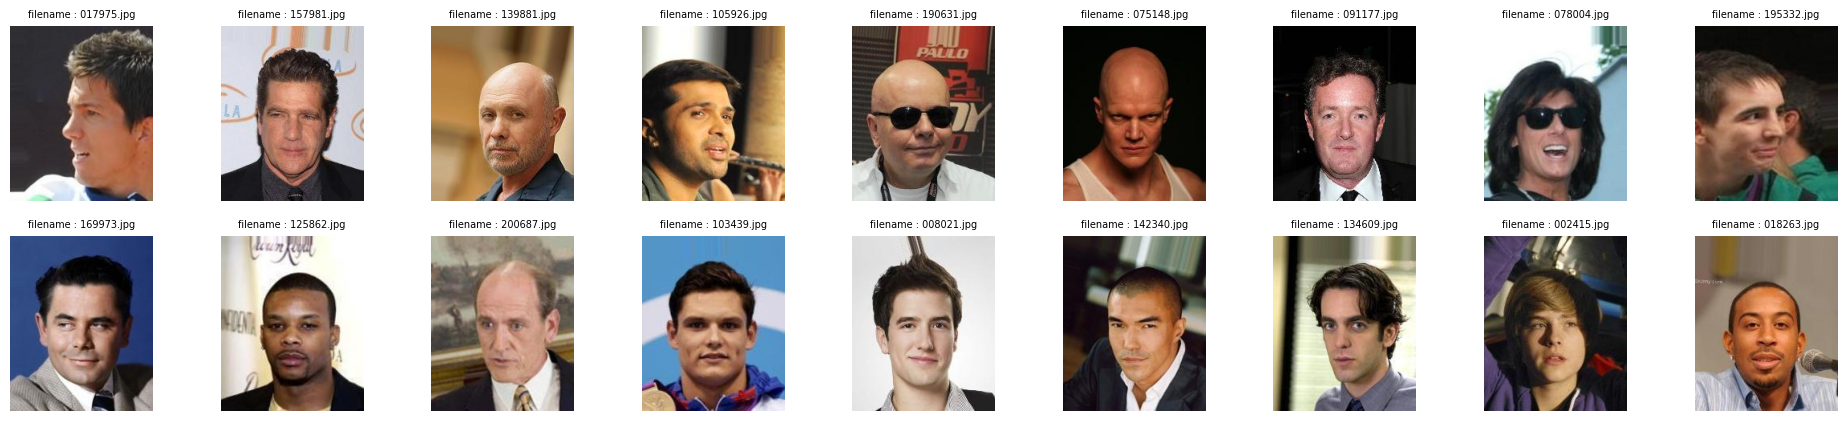

In [11]:
## Sampling random check for male images
x=0
fig = plt.figure(figsize = (24,5))
#for idx, row in df_train[['Filenames']].sample(n=18).iterrows() :
for idx, row in df_train.loc[df_train['Male'] == 'Male', ['Filenames']].sample(n=18).iterrows() :
  f = row[0]
  img_path = f'Dataset/train/{f}'
  #print(img_path)
  img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
  img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA)
  fig.add_subplot(2,9,x+1)
  plt.title(f'filename : {f}', fontsize = 7)
  plt.axis('off')
  plt.imshow(img)
  x += 1

In [12]:
df_test.loc[df_test['Male'] == '1', ['Male']] = 'Male'
df_test.loc[df_test['Male'] == '0', ['Male']] = 'Female'
df_test

,Filenames,Male
0,122315.jpg,Male
1,153759.jpg,Male
2,115290.jpg,Male
3,157437.jpg,Female
4,192358.jpg,Female
...,...,...
995,144965.jpg,Female
996,026421.jpg,Male
997,151442.jpg,Female
998,012915.jpg,Female


/tmp/ipykernel_4242/894865618.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f = row[0]


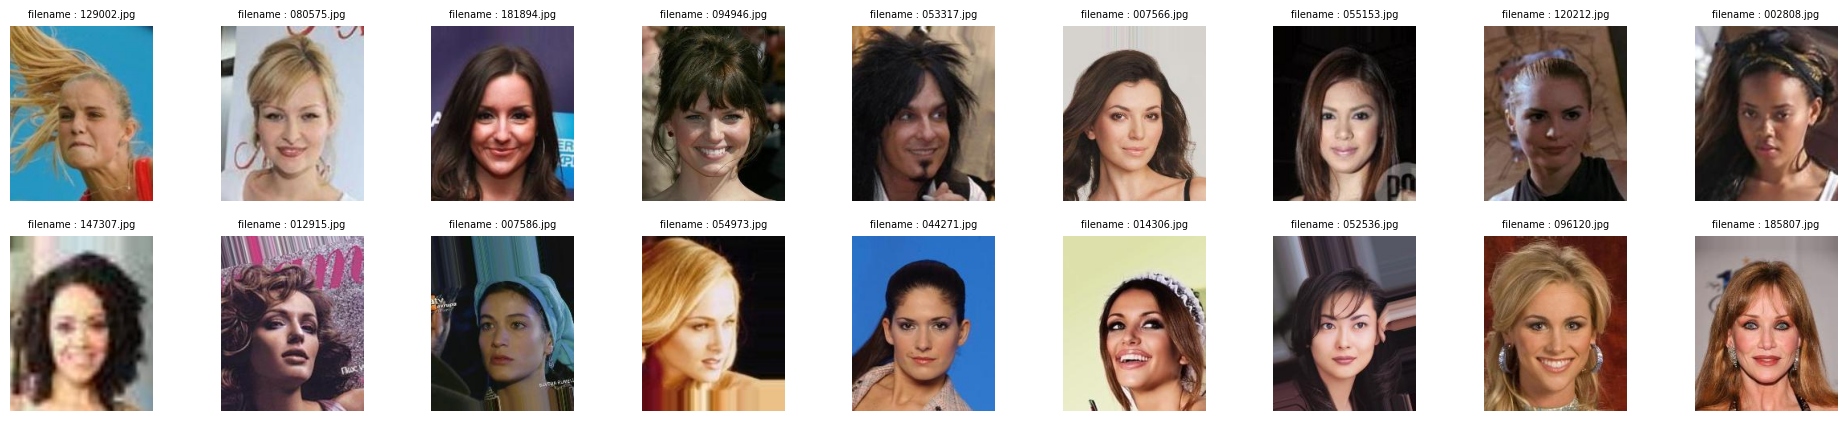

In [13]:
## Sampling random check for Female images
x=0
fig = plt.figure(figsize = (24,5))
#for idx, row in df_train[['Filenames']].sample(n=18).iterrows() :
for idx, row in df_test.loc[df_test['Male'] == 'Female', ['Filenames']].sample(n=18).iterrows() :
  f = row[0]
  img_path = f'Dataset/test/{f}'
  #print(img_path)
  img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
  img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA)
  fig.add_subplot(2,9,x+1)
  plt.title(f'filename : {f}', fontsize = 7)
  plt.axis('off')
  plt.imshow(img)
  x += 1

⏩ We use data augmentation to rich the variation of images. <br>
Data Augmentation is the process of expanding the image training data, by using transformations such as random rotations, shear transforms, shifts zooms and flips, on available image data.

In [14]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    df_train,
    TRAIN_PATH,
    x_col='Filenames',
    y_col='Male',
    target_size=IMG_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 4000 validated image filenames belonging to 2 classes.


In [15]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    df_test,
    TEST_PATH,
    x_col='Filenames',
    y_col='Male',
    target_size=IMG_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 1000 validated image filenames belonging to 2 classes.


## **Training with VGG19 pre-Trained Model**

⏩ Load the pre trained model VGG19 from keras using "imagenet" weight.

In [16]:
base_model = tf.keras.applications.vgg19.VGG19(weights='imagenet', include_top=False, input_shape= IMG_SIZE + (3,))

2024-03-14 22:04:17.540988: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-14 22:04:17.683380: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-14 22:04:17.683696: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-14 22:04:17.685081: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-14 22:04:17.685291: I external/local_xla/xla/stream_executor

⏩ Let's freeze the pre trained model as we want prevent the weights of that layer from being updated during training

In [17]:
base_model.trainable = False
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 218, 178, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 218, 178, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 218, 178, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 109, 89, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 109, 89, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 109, 89, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 54, 44, 128)       0     

⏩ Let's add the custom layer on top of base model

In [18]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 6, 5, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 15360)             0         
                                                                 
 dense (Dense)               (None, 256)               3932416   
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 32)                1

⏩ Compile it using adam optimizer

In [20]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

⏩ Let's define the Checkpoint and other callback function

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint

earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=4,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.001)
# Define a ModelCheckpoint callback to save the model weights during training
checkpoint_callback = ModelCheckpoint(filepath='model_saved/vgg_weights.h5',
                                      save_best_only=True,
                                      save_weights_only=False)

callbacks = [checkpoint_callback, earlystop, learning_rate_reduction]


⏩ Time to train the model with epoch 20. Please pray and sleep early as this process take hours, maybe days 😏 <br>
PS:I left this process without check the progress, as i have to go to my hometown for 3 days 😀

In [22]:
%%time
history = model.fit(train_generator,
                    validation_data = test_generator,
                    validation_steps=len(df_test)//BATCH_SIZE,
                    steps_per_epoch=len(df_train)//BATCH_SIZE,
                    epochs=EPOCH_SIZE,
                    verbose = 1,
                    callbacks=callbacks
                    )

Epoch 1/20


2024-03-14 22:04:20.066731: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-03-14 22:04:22.954353: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f47ba4f40d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-14 22:04:22.954422: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050, Compute Capability 8.6
2024-03-14 22:04:22.971192: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1710428663.075716    4347 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


125/125 [==============================] - 28s 185ms/step - loss: 0.4249 - accuracy: 0.7972 - val_loss: 0.2749 - val_accuracy: 0.8901 - lr: 0.0010
Epoch 2/20


/home/insomnius/.pyenv/versions/3.11.6/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


125/125 [==============================] - 22s 178ms/step - loss: 0.3076 - accuracy: 0.8715 - val_loss: 0.2432 - val_accuracy: 0.9002 - lr: 0.0010
Epoch 3/20
125/125 [==============================] - 22s 174ms/step - loss: 0.2701 - accuracy: 0.8867 - val_loss: 0.2391 - val_accuracy: 0.8982 - lr: 0.0010
Epoch 4/20
125/125 [==============================] - 22s 176ms/step - loss: 0.2522 - accuracy: 0.8985 - val_loss: 0.2433 - val_accuracy: 0.8982 - lr: 0.0010
Epoch 5/20
125/125 [==============================] - 22s 178ms/step - loss: 0.2473 - accuracy: 0.8972 - val_loss: 0.2232 - val_accuracy: 0.9123 - lr: 0.0010
Epoch 6/20
125/125 [==============================] - 22s 176ms/step - loss: 0.2416 - accuracy: 0.8920 - val_loss: 0.2213 - val_accuracy: 0.9022 - lr: 0.0010
Epoch 7/20
125/125 [==============================] - 22s 177ms/step - loss: 0.2335 - accuracy: 0.8995 - val_loss: 0.2110 - val_accuracy: 0.9113 - lr: 0.0010
Epoch 8/20
125/125 [==============================] - 22s 172ms

⏩ Save the history and model after finishing train.

In [23]:
np.save('model_saved/training_history.npy', history.history)
model.save("model_saved/model_finish.h5")

In [24]:
history_vgg19_ep20 = history

In [25]:
print(f"accuracy : {history_vgg19_ep20.history['accuracy'] [-1]}")
print(f"validation accuracy : {history_vgg19_ep20.history['val_accuracy'] [-1]}")

accuracy : 0.921500027179718
validation accuracy : 0.9082661271095276


⏩ Let's continue train again with additional 10 epoch

In [26]:
%%time
history2 = model.fit(train_generator,
                    validation_data = test_generator,
                    validation_steps=len(df_test)//BATCH_SIZE,
                    steps_per_epoch=len(df_train)//BATCH_SIZE,
                    epochs=10,
                    verbose = 1,
                    callbacks=callbacks
                    )

Epoch 1/10
125/125 [==============================] - 22s 178ms/step - loss: 0.1738 - accuracy: 0.9293 - val_loss: 0.1914 - val_accuracy: 0.9294 - lr: 0.0010
Epoch 2/10
125/125 [==============================] - 22s 178ms/step - loss: 0.1632 - accuracy: 0.9300 - val_loss: 0.2026 - val_accuracy: 0.9284 - lr: 0.0010
Epoch 3/10
125/125 [==============================] - 22s 176ms/step - loss: 0.1581 - accuracy: 0.9335 - val_loss: 0.1802 - val_accuracy: 0.9274 - lr: 0.0010
Epoch 4/10
125/125 [==============================] - 22s 173ms/step - loss: 0.1736 - accuracy: 0.9277 - val_loss: 0.1909 - val_accuracy: 0.9284 - lr: 0.0010
Epoch 5/10
125/125 [==============================] - 22s 172ms/step - loss: 0.1505 - accuracy: 0.9377 - val_loss: 0.1865 - val_accuracy: 0.9294 - lr: 0.0010
Epoch 6/10
125/125 [==============================] - 22s 173ms/step - loss: 0.1642 - accuracy: 0.9305 - val_loss: 0.1916 - val_accuracy: 0.9244 - lr: 0.0010
Epoch 7/10
125/125 [==============================] 

⏩ Save the history and model

In [27]:
np.save('model_saved/training_history2.npy', history.history)
model.save("model_saved/model_finish2.h5")

In [28]:
np.save('model_saved/training_history2_vgg19_ep30.npy', history2.history)
history_vgg19_ep30 = history2

## **Training with VGG16 pre-Trained Model**

⏩ Load the pre trained model VGG19 from keras using "imagenet" weight.

In [29]:
base_model16 = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape= IMG_SIZE + (3,))

⏩ Freeze the base model

In [30]:
base_model16.trainable = False
base_model16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 218, 178, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 218, 178, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 218, 178, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 109, 89, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 109, 89, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 109, 89, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 54, 44, 128)       0     

⏩ Add custom model on top of base model

In [31]:
model2 = Sequential()
model2.add(base_model16)
model2.add(Flatten())
model2.add(Dense(256,activation='relu'))
model2.add(Dense(256,activation='relu'))
model2.add(Dense(64,activation='relu'))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(2, activation='sigmoid'))
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 5, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 15360)             0         
                                                                 
 dense_6 (Dense)             (None, 256)               3932416   
                                                                 
 dense_7 (Dense)             (None, 256)               65792     
                                                                 
 dense_8 (Dense)             (None, 64)                16448     
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 32)               

In [32]:
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [33]:
from tensorflow.keras.callbacks import ModelCheckpoint

earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=4,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.001)
# Define a ModelCheckpoint callback to save the model weights during training
checkpoint_callback = ModelCheckpoint(filepath='model_saved/vgg_weights16.h5',
                                      save_best_only=True,
                                      save_weights_only=False)

In [34]:
callbacks = [checkpoint_callback, earlystop, learning_rate_reduction]

⏩ Time to train the model with epoch 20

In [35]:
%%time
history3 = model2.fit(train_generator,
                    validation_data = test_generator,
                    validation_steps=len(df_test)//BATCH_SIZE,
                    steps_per_epoch=len(df_train)//BATCH_SIZE,
                    epochs=EPOCH_SIZE,
                    verbose = 1,
                    callbacks=callbacks
                    )

Epoch 1/20
125/125 [==============================] - 22s 169ms/step - loss: 0.3688 - accuracy: 0.8370 - val_loss: 0.2337 - val_accuracy: 0.9153 - lr: 0.0010
Epoch 2/20
125/125 [==============================] - 21s 165ms/step - loss: 0.2738 - accuracy: 0.8815 - val_loss: 0.1924 - val_accuracy: 0.9365 - lr: 0.0010
Epoch 3/20
125/125 [==============================] - 21s 168ms/step - loss: 0.2328 - accuracy: 0.9070 - val_loss: 0.1901 - val_accuracy: 0.9244 - lr: 0.0010
Epoch 4/20
125/125 [==============================] - 21s 168ms/step - loss: 0.2301 - accuracy: 0.8997 - val_loss: 0.1900 - val_accuracy: 0.9335 - lr: 0.0010
Epoch 5/20
125/125 [==============================] - 21s 168ms/step - loss: 0.2205 - accuracy: 0.9078 - val_loss: 0.1829 - val_accuracy: 0.9325 - lr: 0.0010
Epoch 6/20
125/125 [==============================] - 20s 160ms/step - loss: 0.1896 - accuracy: 0.9210 - val_loss: 0.2159 - val_accuracy: 0.9315 - lr: 0.0010
Epoch 7/20
125/125 [==============================] 

In [36]:
np.save('model_saved/training_history2.npy', history2.history)

In [37]:
np.save('model_saved/training_history3.npy', history3.history)
model2.save("model_saved/model_finishvgg16_20.h5")

In [38]:
np.save('model_saved/training_history_vgg16_ep20.npy', history3.history)
history_vgg16_ep20 = history3

⏩ Continue Train with additional epoch 10

In [39]:
%%time
history4 = model2.fit(train_generator,
                    validation_data = test_generator,
                    validation_steps=len(df_test)//BATCH_SIZE,
                    steps_per_epoch=len(df_train)//BATCH_SIZE,
                    epochs=10,
                    verbose = 1,
                    callbacks=callbacks
                    )

Epoch 1/10
125/125 [==============================] - 20s 163ms/step - loss: 0.1369 - accuracy: 0.9450 - val_loss: 0.1752 - val_accuracy: 0.9335 - lr: 0.0010
Epoch 2/10
 67/125 [===============>..............] - ETA: 7s - loss: 0.1133 - accuracy: 0.9515

125/125 [==============================] - 20s 162ms/step - loss: 0.1213 - accuracy: 0.9500 - val_loss: 0.2569 - val_accuracy: 0.9264 - lr: 0.0010
Epoch 3/10
125/125 [==============================] - 20s 161ms/step - loss: 0.1304 - accuracy: 0.9495 - val_loss: 0.2962 - val_accuracy: 0.9214 - lr: 0.0010
Epoch 4/10
125/125 [==============================] - 20s 162ms/step - loss: 0.1238 - accuracy: 0.9498 - val_loss: 0.1565 - val_accuracy: 0.9415 - lr: 0.0010
Epoch 5/10
125/125 [==============================] - 20s 163ms/step - loss: 0.1283 - accuracy: 0.9505 - val_loss: 0.1546 - val_accuracy: 0.9345 - lr: 0.0010
Epoch 6/10
125/125 [==============================] - 20s 163ms/step - loss: 0.1226 - accuracy: 0.9535 - val_loss: 0.1822 - val_accuracy: 0.9284 - lr: 0.0010
Epoch 7/10
125/125 [==============================] - 20s 161ms/step - loss: 0.1222 - accuracy: 0.9500 - val_loss: 0.2063 - val_accuracy: 0.9214 - lr: 0.0010
Epoch 8/10
125/125 [==============================] - 20s 161ms

⏩ Save the history and model

In [40]:
np.save('model_saved/training_history4.npy', history4.history)
model2.save("model_saved/model_finishvgg16_30.h5")

In [41]:
np.save('model_saved/training_history_vgg16_ep30.npy', history4.history)
history_vgg16_ep30 = history4

## **Plot the History**

In [42]:
def plot_history(history, title):
    ## accuracy
    plt.figure(figsize=(18, 4))
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.legend()
    plt.title(f'Accuracy {title}')
    #plt.title('Model Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

    # loss function
    plt.figure(figsize=(18, 4))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='valid')
    plt.legend()
    plt.title(f'Loss {title}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

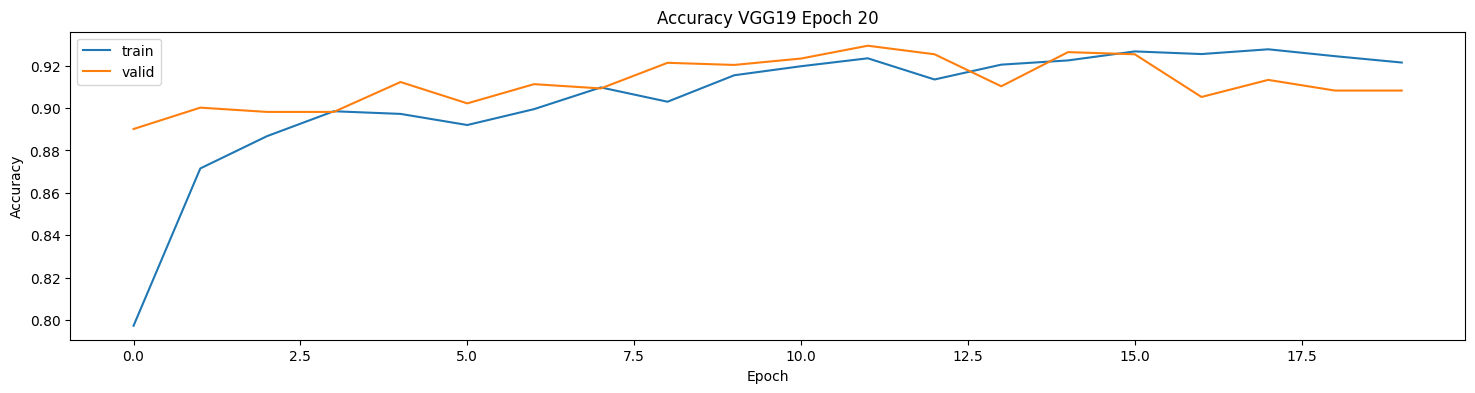

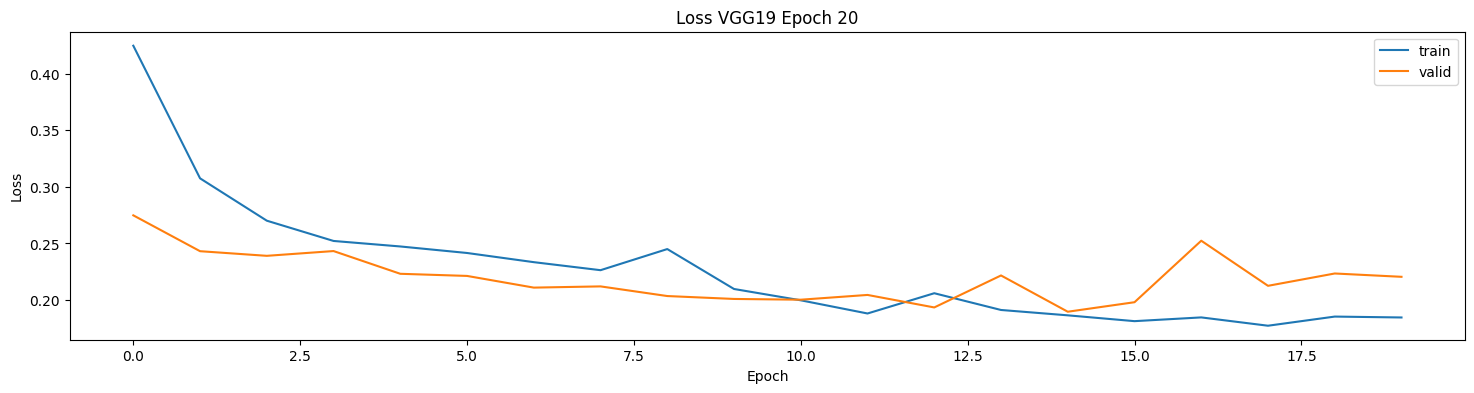

In [43]:
plot_history(history_vgg19_ep20, 'VGG19 Epoch 20')

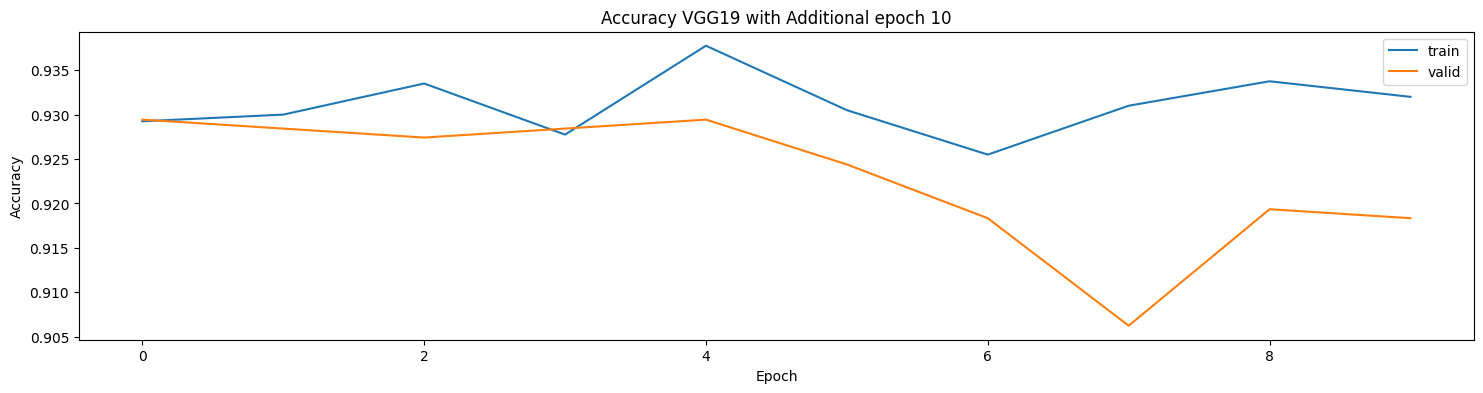

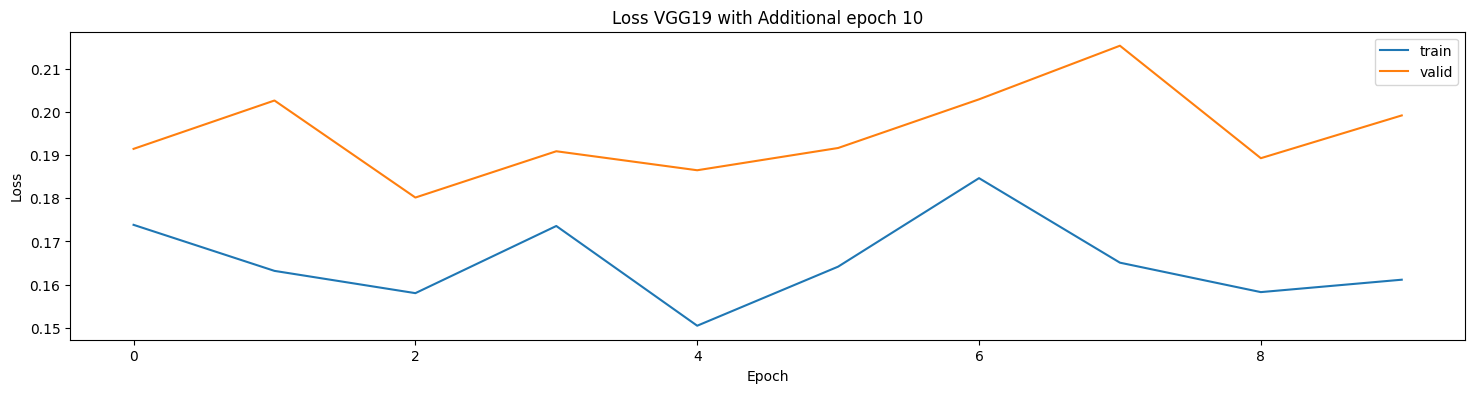

In [44]:
plot_history(history_vgg19_ep30, 'VGG19 with Additional epoch 10')

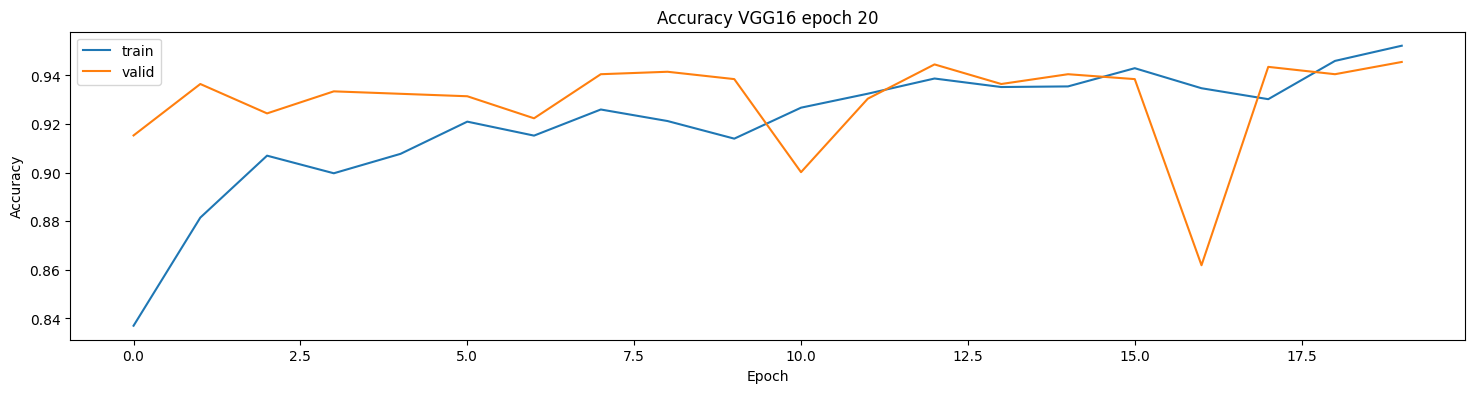

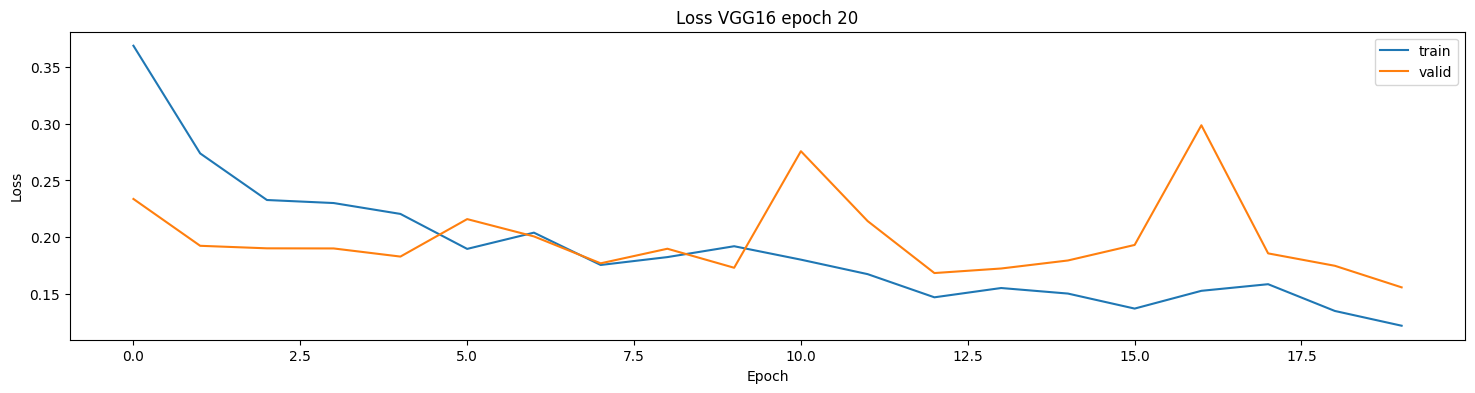

In [45]:
plot_history(history_vgg16_ep20, 'VGG16 epoch 20')

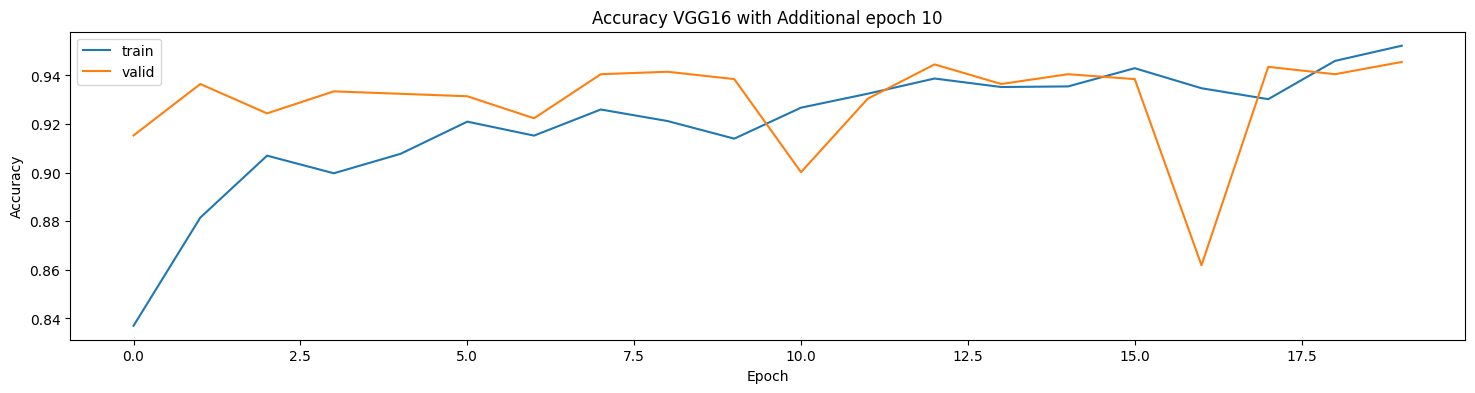

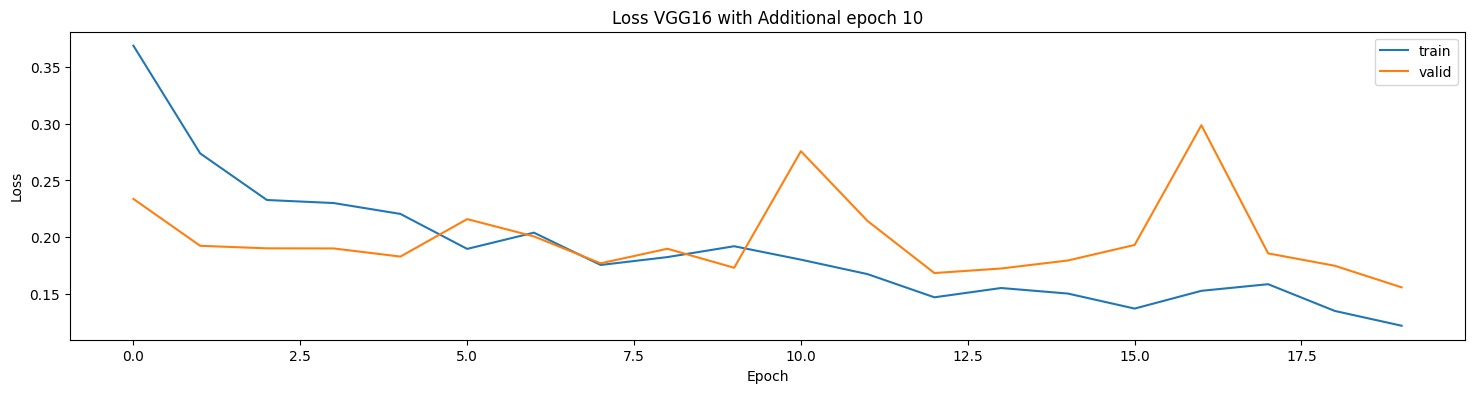

In [46]:
plot_history(history_vgg16_ep20, 'VGG16 with Additional epoch 10')